In [1]:
!pip install -q tensorboard ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.0/793.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.0 MB/s eta 0:00:00


In [2]:
# to download the dataset from roboflow
!pip install ultralytics==8.0.196

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.2.42
    Uninstalling ultralytics-8.2.42:
      Successfully uninstalled ultralytics-8.2.42


In [3]:
import os
import time
import json
import requests
from zipfile import ZipFile
from shutil import copyfile
from dataclasses import dataclass, field

import yaml
import glob

import random
import numpy as np
import pandas as pd
import cv2
import tensorflow

from ultralytics import YOLO

import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = '/content/drive/MyDrive/ARPA/data/sound_horse'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

In [6]:
%cd $base_path

/content/drive/MyDrive/ARPA/data/sound_horse


In [ ]:
# Downloaded dataset from roboflow
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="c0lwt8cmIxNhnzQ8OYFn")
# project = rf.workspace("saumort").project("horses-upigv")
# version = project.version(4)
# dataset = version.download("yolov8")

import os
import shutil

# Create directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Move files to respective directories
move_files(os.path.join(sound_horse.location, 'train'), train_path)
move_files(os.path.join(sound_horse.location, 'test'), test_path)
move_files(os.path.join(sound_horse.location, 'valid'), val_path)

print("Dataset organized into train, test, val directories in Google Drive.")


NameError: name 'move_files' is not defined

In [7]:
%cd $train_path

/content/drive/MyDrive/ARPA/data/sound_horse/train


In [8]:
%ls $train_path

images/  labels/  labels.cache


In [9]:
# create classes for detection: 0= sound, 1= lame but there is only one class for now, will merge two dataset and assign class id later
CLASS_ID = 0

In [10]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.
    vis_ones = np.where(lm_kpts[:, -1] == 1.)
    lm_kpts[vis_ones, -1] = 2.

    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    norm_kps_per_img[:, :-1]  = norm_kps_per_img[:, :-1] / res_lm_array

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [11]:
TRAIN_LABEL_PATH = os.path.join(train_path, 'labels')
TRAIN_IMG_PATH = os.path.join(train_path, 'images')

VALID_LABEL_PATH = os.path.join(val_path,'labels')
VALID_IMG_PATH = os.path.join(val_path, 'images')

TEST_IMG_PATH = os.path.join(test_path, 'images')
TEST_LABEL_PATH = os.path.join(test_path, 'labels')

In [12]:
%ls $VALID_IMG_PATH

25-Black-Horse-Dream-Meaning-and-_jpg.rf.9ff730232e560b71715c9f15a91e0fe5.jpg
54-000-Black-Horse-Stock-Photos-_jpg.rf.5e4df6f8dad13144779785c4352eeb4f.jpg
A-black-horse-with-a-gold-medallion-on-_jpg.rf.5f48f1d81058dd634d37e61443998223.jpg
A-black-horse-with-a-long-mane-is-_jpg.rf.e7a0f41d2c06398590714ad7dddba46b.jpg
An-insanely-beautiful-horse-_-r_pics_jpg.rf.bb33ed22d0ca75aaaa1aee26ca75dbdb.jpg
A-sensational-mover-of-high-quality_jpg.rf.f48bd69dbcbca5ff25332df6709e9c33.jpg
Beautiful-brown-horse-with-a-black-mane-_jpg.rf.76788f5f5a50528bc225534bf685f3bb.jpg
Beautiful-brown-horse-with-black-manes-_jpg.rf.7db63abbe2e7d378011c6987f0d96f24.jpg
Black-Dress-Holding-the-Black-Horse-_jpg.rf.55d7ac8247639eec579952cbcd111c56.jpg
Black-Horse-Running-Stock-Photos-1-_jpg.rf.16e8f7dcfdbc5fa04dc765b5a9002c18.jpg
Blue-Hors-Londoner-_-GLOBAL-EQUINE-SIRES-2-_jpg.rf.c6928de017c4297862aeafb9936b529d.jpg
Blue-Hors-Londoner-_-Hengsthaltung-2-_jpg.rf.63c40d47dac63675e9b54420dd7f0495.jpg
Blue-Hors-Veneziano-_

In [13]:
train_images = os.listdir(TRAIN_IMG_PATH)
valid_images = os.listdir(VALID_IMG_PATH)
test_images = os.listdir(TEST_IMG_PATH)
print(f"Training images: {len(train_images)}, Validation Images: {len(valid_images)}, Test images:  {len(test_images)}" )

Training images: 280, Validation Images: 80, Test images:  40


In [14]:
!pip install pyyaml

In [15]:
%cd /content/drive/MyDrive/ARPA/data/sound_horse/Horses-4/

/content/drive/MyDrive/ARPA/data/sound_horse/Horses-4


In [16]:
import yaml

if __name__ == '__main__':
    with open("data.yaml", 'r') as stream:
        dictionary = yaml.load(stream, Loader=yaml.SafeLoader)
        for key, value in dictionary.items():
            print(key + " : " + str(value))


flip_idx : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
kpt_shape : [16, 3]
names : ['horse']
nc : 1
roboflow : {'license': 'CC BY 4.0', 'project': 'horses-upigv', 'url': 'https://universe.roboflow.com/saumort/horses-upigv/dataset/4', 'version': 4, 'workspace': 'saumort'}
test : test/images
train : train/images
val : valid/images


In [17]:
default_color = (255,255,255)
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        #color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   default_color,
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [18]:
def draw_boxes(image, detections, class_name = "horse", score=None, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, xmax, ymax = detections[:4].astype("int").tolist()
    conf = round(float(detections[-1]),2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)

    display_text = f"{class_name}"

    if score is not None:
        display_text+=f": {score:.2f}"

    (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                   cv2.FONT_HERSHEY_SIMPLEX,
                                                   font_size, 2)

    cv2.rectangle(image,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color=color, thickness=-1)

    image = cv2.putText(
                    image,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (0, 0, 0),
                    2, lineType=cv2.LINE_AA,
                )

    return image

In [19]:
def visualize_annotations(image, box_data, keypoints_data):

    image = image.copy()

    shape_multiplier = np.array(image.shape[:2][::-1]) # (W, H).
    # Final absolute coordinates (xmin, ymin, xmax, ymax).
    denorm_boxes = np.zeros_like(box_data)

    # De-normalize center coordinates from YOLO to (xmin, ymin).
    denorm_boxes[:, :2] = (shape_multiplier/2.) * (2*box_data[:,:2] - box_data[:,2:])

    # De-normalize width and height from YOLO to (xmax, ymax).
    denorm_boxes[:, 2:] = denorm_boxes[:,:2] + box_data[:,2:]*shape_multiplier

    for boxes, kpts in zip(denorm_boxes, keypoints_data):
        # De-normalize landmark coordinates.
        kpts[:, :2]*= shape_multiplier
        image = draw_boxes(image, boxes)
        image = draw_landmarks(image, kpts)

    return image

In [20]:
IMAGE_FILES = os.listdir(TRAIN_IMG_PATH)
NUM_LANDMARKS = 16

num_samples = 8
num_rows = 2
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(45)
random.shuffle(IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(IMAGE_FILES[:num_samples], ax.flat)):

    image = cv2.imread(os.path.join(TRAIN_IMG_PATH, file))

    # Obtain the txt file for the corresponding image file.
    filename, extension = os.path.splitext(file)
    # Split each object instance in separate lists.
    with open(os.path.join(TRAIN_LABEL_PATH, filename+".txt"), "r") as file:
        label_data = [x.split() for x in file.read().strip().splitlines() if len(x)]

    label_data = np.array(label_data, dtype=np.float32)

    # YOLO BBox instances in [x-center, y-center, width, height] in normalized form.
    box_instances = label_data[:,1:5]
    # Shape: (N, 4), where, N = #instances per-image

    # Kpt instances.
    # Filter keypoints based on visibility.
    instance_kpts = []
    kpts_data = label_data[:,5:].reshape(-1, NUM_LANDMARKS, 3)

    for inst_kpt in kpts_data:
        vis_ids = np.where(inst_kpt[:, -1]>0.)[0]
        vis_kpts = inst_kpt[vis_ids][:,:2]
        vis_kpts = np.concatenate([vis_kpts, np.expand_dims(vis_ids, axis=-1)], axis=-1)
        instance_kpts.append(vis_kpts)

    image_ann = visualize_annotations(image, box_instances, instance_kpts)
    axis.imshow(image_ann[...,::-1])
    axis.axis("off")


plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [21]:
@dataclass(frozen=False)
class TrainingConfig:
    DATASET_YAML:   str = "data.yaml"
    MODEL:          str = "yolov8n-pose.pt"
    MODEL_NAME:     str = "yolov8n-pose"
    EPOCHS:         int = 100
    KPT_SHAPE:    tuple = (16,3)
    PROJECT:        str = "Animal_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "horse"})

In [22]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0 # Turn off horizontal flip.

In [23]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [24]:
%cd $base_path

/content/drive/MyDrive/ARPA/data/sound_horse


In [25]:
current_dir = os.getcwd()
current_dir

'/content/drive/MyDrive/ARPA/data/sound_horse'

In [26]:
current_dir = os.getcwd()

data_dict = dict(
                path      = base_path,
                train     = os.path.join(train_path, TRAIN_IMG_PATH),
                val       = os.path.join(val_path, VALID_IMG_PATH),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

In [27]:
pose_model = model = YOLO(train_config.MODEL)

pose_model.train(data    = train_config.DATASET_YAML,
            epochs       = train_config.EPOCHS,
            imgsz        = data_config.IMAGE_SIZE,
            batch        = data_config.BATCH_SIZE,
            project      = train_config.PROJECT,
            name         = train_config.NAME,
            close_mosaic = data_config.CLOSE_MOSAIC,
            mosaic       = data_config.MOSAIC,
            fliplr       = data_config.FLIP_LR
           )

New https://pypi.org/project/ultralytics/8.2.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Animal_Keypoints, name=yolov8n-pose_100_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, aug

KeyboardInterrupt: 

In [28]:
ckpt_path  = os.path.join(train_config.PROJECT, train_config.NAME, "weights2", "best2.pt")
model_pose = YOLO(ckpt_path)

metrics = model_pose.val()

FileNotFoundError: [Errno 2] No such file or directory: 'Animal_Keypoints/yolov8n-pose_100_epochs/weights2/best2.pt'

In [ ]:
def prepare_predictions(
    image_dir_path,
    image_filename,
    model,
    BOX_IOU_THRESH = 0.55,
    BOX_CONF_THRESH=0.30,
    KPT_CONF_THRESH=0.68):

    image_path = os.path.join(image_dir_path, image_filename)
    image = cv2.imread(image_path).copy()

    results = model.predict(image_path, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

    if not len(results.boxes.xyxy):
        return image

    # Get the predicted boxes, conf scores and keypoints.
    pred_boxes = results.boxes.xyxy.numpy()
    pred_box_conf = results.boxes.conf.numpy()
    pred_kpts_xy = results.keypoints.xy.numpy()
    pred_kpts_conf = results.keypoints.conf.numpy()

    # Draw predicted bounding boxes, conf scores and keypoints on image.
    for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
        kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
        filter_kpts = kpts[kpts_ids]
        filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
        image = draw_boxes(image, boxes, score=score)
        image = draw_landmarks(image, filter_kpts)

    return image

In [ ]:
VAL_IMAGE_FILES = os.listdir(VALID_IMG_PATH)

num_samples = 9
num_rows = 3
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(90)
random.shuffle(VAL_IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(VAL_IMAGE_FILES[:num_samples], ax.flat)):

    image_pred = prepare_predictions(VALID_IMG_PATH, file, model_pose)
    axis.imshow(image_pred[...,::-1])
    axis.axis("off")

plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%cd /content/drive/MyDrive/ARPA/sound_horse/runs/pose/train/

/content/drive/MyDrive/ARPA/sound_horse/runs/pose/train


In [ ]:
if __name__ == '__main__':
    with open("args.yaml", 'r') as stream:
        dictionary = yaml.load(stream, Loader=yaml.SafeLoader)
        for key, value in dictionary.items():
            print(key + " : " + str(value))

task : pose
mode : train
model : yolov8n-pose.pt
data : /content/drive/MyDrive/ARPA/sound_horse/train
epochs : 5
patience : 50
batch : 16
imgsz : 640
save : True
save_period : -1
cache : False
device : None
workers : 8
project : None
name : None
exist_ok : False
pretrained : True
optimizer : auto
verbose : True
seed : 0
deterministic : True
single_cls : False
rect : False
cos_lr : False
close_mosaic : 10
resume : False
amp : True
fraction : 1.0
profile : False
freeze : None
overlap_mask : True
mask_ratio : 4
dropout : 0.0
val : True
split : val
save_json : False
save_hybrid : False
conf : None
iou : 0.7
max_det : 300
half : False
dnn : False
plots : True
source : None
show : False
save_txt : False
save_conf : False
save_crop : False
show_labels : True
show_conf : True
vid_stride : 1
stream_buffer : False
line_width : None
visualize : False
augment : False
agnostic_nms : False
classes : None
retina_masks : False
boxes : True
format : torchscript
keras : False
optimize : False
int8 : Fal

In [ ]:
IMG_PATH = '/content/drive/MyDrive/ARPA/data/Lame horses/1.mp4'

In [ ]:
%cd /content/drive/MyDrive/ARPA/sound_horse/Animal_Keypoints/yolov8n-pose_100_epochs/weights/

/content/drive/MyDrive/ARPA/sound_horse/Animal_Keypoints/yolov8n-pose_100_epochs/weights


In [ ]:
!yolo predict model=best.pt source= '/content/drive/MyDrive/ARPA/data/Lame horses/1.mp4' conf=.7

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-pose summary (fused): 187 layers, 3268931 parameters, 0 gradients, 9.1 GFLOPs

video 1/1 (1/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 269.8ms
video 1/1 (2/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 188.2ms
video 1/1 (3/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 137.6ms
video 1/1 (4/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 150.0ms
video 1/1 (5/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 142.8ms
video 1/1 (6/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 139.3ms
video 1/1 (7/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 134.5ms
video 1/1 (8/1729) /content/drive/MyDrive/ARPA/data/Lame horses/1.mp4: 384x640 1 horse, 145.5ms
video 1/1 (9/1729) /content/drive/MyDrive/ARPA/data/Lame hor

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


0: 640x640 1 horse, 319.0ms
Speed: 7.4ms preprocess, 319.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/ARPA/data/sound_horse/train/images/11-Black-and-White-Horse-Breeds-with-_jpg.rf.bf221ecf541b08703e4bb3b4fc504d29.jpg: 640x640 1 horse, 391.5ms
Speed: 2.9ms preprocess, 391.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


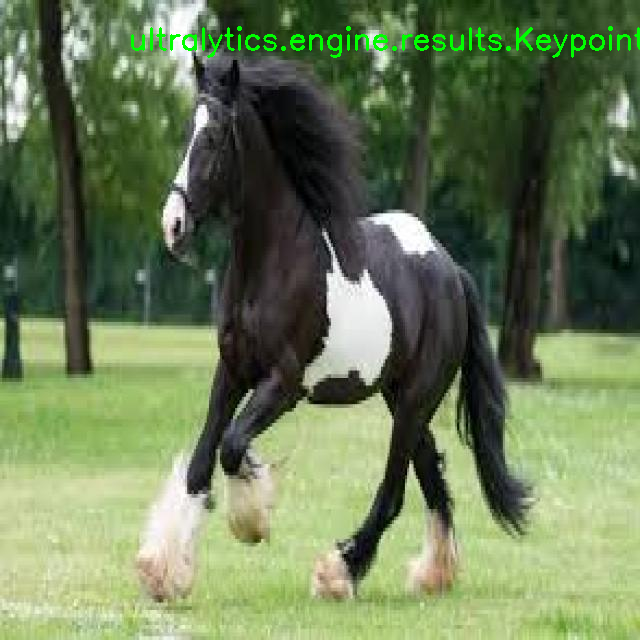

-1

In [18]:
from google.colab.patches import cv2_imshow
model_path = "/content/drive/MyDrive/ARPA/data/sound_horse/Animal_Keypoints/yolov8n-pose_100_epochs/weights/best.pt"
img_path = "/content/drive/MyDrive/ARPA/data/sound_horse/train/images/11-Black-and-White-Horse-Breeds-with-_jpg.rf.bf221ecf541b08703e4bb3b4fc504d29.jpg"

model = YOLO(model_path)
img = cv2.imread(img_path)
results = model.predict(source=img, show=True)

result = model(img_path)[0]
for result in results:
  for keypoints_idx, keypoints in enumerate(result.keypoints.numpy()):
    cv2.putText(img, str(keypoints), (int(result.boxes.xyxy[0][0]), int(result.boxes.xyxy[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(img)
cv2.waitKey(0)
